# Main Document for Group 3 #

## Specifications 
(1) Combine posts (ideas) and related comments into one "document"

(2) Then run TD Matrix: Topic modeling, non-negative matrix factorization

(3) Exclude irrelavant topics. If a given thread has a majority weight within the following topics, they are removed: "Food", "Drinks", "Fredagsbar", "Cantine", "Made in America", "Translate ideas", "Garbage cans", "P-Shop". After that, proceed with all the threads that were not excluded 

(4) Combine all related comments for each post into one "document" (not including the actual post) 

(5) Then run a sentiment analysis on these documents 

(6) Rank the posts based on the sentiment analysis of their comments

(7) Exclude the bottom half of the posts (OR at least all negative). Then proceed with the threads that were not excluded

(8) Rank the remaining ideas based on the following weights (comments: 60%, likes: 35%, likes on comments: 5%) 

Side note: extra run

(e1) Remove threads with stop words from step 3. Removing the irrelevant words/posts

(e2) Rank the dataset using scores from step 8 

## step 0: install packages & read data 
NB: this takes a minute or two.

In [19]:
%%capture
!pip install -r requirements.txt
!python setup.py install 
from nonnegfac.nmf import NMF # topic model (nonnegative matrix factorization)
from util import read_data # read data (Nielbo)
from fun import * # custom functions
import pandas as pd # working with dataframes
import numpy as np # working with arrays
import networkx as nx # working with networks / graphs
import re # working with strings  
from sklearn.feature_extraction.text import TfidfVectorizer # topic model (nonnegative matrix factorization)
from sklearn.metrics import pairwise_distances # topic model (nonnegative matrix factorization) 
from sklearn.feature_extraction import text # topic model (nonnegative matrix factorization)
import matplotlib.pyplot as plt # plotting / visualization
import seaborn as sns # plotting / visualization
from flair.data import Sentence # sentiment analysis
from flair.models import TextClassifier # sentiment analysis
classifier = TextClassifier.load("en-sentiment") # sentiment analysis
import warnings # one warning that we want to silence
from pandas.core.common import SettingWithCopyWarning # warning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning) # silence warning
warnings.simplefilter(action='ignore', category=FutureWarning) # silence warning

2022-04-30 13:51:11,000 loading file /home/ucloud/.flair/models/sentiment-en-mix-distillbert_4.pt


In [2]:
# read data
(ideas, comments, ideator) = read_data()

# step 1: combine posts and comments

In [3]:
ideas_txt = ideas[["Submission.ID", "Title", "Body"]] # select id and text columns
comments_txt = comments[["Submission.ID", "Comment"]] # select id and text columns
comments_joined = comments_txt.groupby(['Submission.ID'])['Comment'].apply(lambda x: ' '.join(x)).reset_index() # combine comments
ideas_comments = ideas_txt.merge(comments_joined, on = "Submission.ID", how = "left") # merge ideas & comments (keep posts without comments)
ideas_comments["text"] = ideas_comments["Title"].astype(str) + " " + ideas_comments["Body"].astype(str) + " " + ideas_comments["Comment"].astype(str) # combine posts and comments
ideas_comments.head(3) # print it 

,Submission.ID,Title,Body,Comment,text
0,4,Make it easier to open the box,Often I see a LEGO box get torn open because i...,"Thank you Camilla, that would be great! Whethe...",Make it easier to open the box Often I see a L...
1,91,Reconnect with childhood,When taking visitors through the Idea House I ...,I felt so nostalgic the day I saw horses in th...,Reconnect with childhood When taking visitors ...
2,205,LEGO City Counstryside,Hi :) During the christmas holiday I was play...,"I was thinking of some diffrents farms, with t...",LEGO City Counstryside Hi :) During the christ...


## step 1.1: clean text 

In [4]:
# step 1.1: basic text cleaning
def normalizing_text(text):
    cleanr = re.compile('<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
    text = re.sub(cleanr, ' ', text)
    text = text.lower() #lower case
    text = re.sub(r'http\S+', ' ', text) # removes everything after http
    text = re.sub(r"@[^\s]+", " ", text) # remove handles / mentions (everything before whitespace)
    text = re.sub(r"/", " ", text) # replace slash with space 
    text = re.sub(r"_", " ", text) # replace underscore with space (important after "@[^\s]+")
    text = re.sub(r'[^\w\s]', "", text) # remove punctuation and emojis
    text = re.sub(r'\d+', ' ', text) # 
    text = re.sub(r'\W+', ' ', text) # 
    text = re.sub(r'\s+', ' ', text) # excess whitespace with single whitespace
    return text    

# use the function on our text column
ideas_comments["clean_txt"] = [normalizing_text(x) for x in ideas_comments["text"]]

# step 2: Run nonnegative matrix factorization
NB: takes a minute to run. <br/>
NB: as the number of desired topics was not specified, 5 topics was chosen

In [5]:
%%capture
# step 2: run nonnegative matrix factorization (topic modeling) --> takes ~1-2 minutes #
# preparation
data = ideas_comments[~ideas_comments["clean_txt"].isnull()] # cannot have empty text 
content_norm = data["clean_txt"].values # only take the text out now

# remove stopwords (english)
swfilter = text.ENGLISH_STOP_WORDS.union()

# number of features (words/tokens) to consider (i.e. the top 2000 words by frequency)
no_features = 2000

# vectorize
vectorizer = TfidfVectorizer(
        max_features = no_features,
        ngram_range = (1,1),
        max_df = .25,
        stop_words = swfilter
        )

X = vectorizer.fit_transform(content_norm)
features = vectorizer.get_feature_names_out() # was get_feature_names() but deprecated
    
# for reproducibility
np.random.seed(1234)
k = 5 # number of topics
W, H, info = NMF().run(X, k, max_iter = 100, verbose=0) # actually run topic modeling: ~1-2 minutes

## step 2.1: inspect our 5 topics (10 most important words in each)

In [6]:
# step 2.1: inspect our 5 topis (10 most common words) # 
no_top_words = 10 # display 10 top words
# def display_topics(H, feature_names, no_top_words, filename="dimensions.txt"):
for topic_idx, topic in enumerate(H.T):
            #print(f"dimension {topic_idx}:")
            s = f"dimension-{topic_idx}: " + " ".join([features[i]+", "
                        for i in topic.argsort()[:-no_top_words - 1:-1]])
            print(s)

dimension-0: bags,  bag,  boxes,  plastic,  storage,  solution,  smart,  open,  ziplock,  minifigures, 
dimension-1: models,  instructions,  instruction,  alternate,  black,  boxes,  qr,  colour,  people,  family, 
dimension-2: game,  figures,  skylanders,  figure,  built,  virtual,  friends,  games,  world,  character, 
dimension-3: calendar,  advent,  day,  christmas,  winter,  calendars,  year,  city,  small,  theme, 
dimension-4: ideas,  app,  stores,  collection,  brand,  store,  similar,  thanks,  house,  london, 


## step 2.2: pairwise distances (between topics & threads)
NB: This is necessary for plotting topic relations (which we discussed). <br/>
There are 5 topics, so the distance matrix (how far appart the topics are) will have dimension (5, 5) <br/>
There are 108 threads, so the distance matrix (how far appart threads are) will have dimension (108, 108) <br/>

In [7]:
# step 2.2: pairwise distances between (topics, topics) and (threads, threads) #
distance_threads = pairwise_distances(W, metric = "cosine")
distance_topics = pairwise_distances(W.T, metric = "cosine")

# check data
print(f"threads x threads distance matrix: {distance_threads.shape}") # (108, 108) threads x threads
print(f"topics x topics distance matrix: {distance_topics.shape}") # (5, 5) topics x topics

threads x threads distance matrix: (108, 108)
topics x topics distance matrix: (5, 5)


Let us look at the distance matrix to understand what we are plotting. <br/>
This matrix is the distance matrix between topics (5 x 5) which we will visualize <br/>
All elements on the diagonal are 0 because each element has 0 distance to itself. <br/>
The smaller the values are the "closer" the topics are together. <br/>
Notice that the matrix is symmetric (element (1, 2) has the same value as (2, 1)).

In [8]:
print(distance_topics)

[[0.         0.89626478 0.93401935 0.95407927 0.94232965]
 [0.89626478 0.         0.87095276 0.89349773 0.86939054]
 [0.93401935 0.87095276 0.         0.9244801  0.90408232]
 [0.95407927 0.89349773 0.9244801  0.         0.92462427]
 [0.94232965 0.86939054 0.90408232 0.92462427 0.        ]]


## step 2.3: visualize semantic topic relations
NB: the code for this is in the file fun.py

In [17]:
d = prepare_network(distance_topics) # function from fun.py
d.head(3) # check data

,src,trg,dist,weight
0,0,1,0.896265,0.103735
1,0,2,0.934019,0.065981
2,0,3,0.954079,0.045921


In [12]:
# create network #
G = nx.from_pandas_edgelist(
    d, # our dataframe 
    source = "src", # first column (source)
    target = "trg", # second column (target)
    edge_attr = "weight" # edge attribute (weight) 
)

In [13]:
node_size_list, node_color_list, node_label_dict = set_node_attributes(G) # function from fun.py

In [14]:
edge_width_list, edge_color_list = set_edge_attributes(G) # function from fun.py

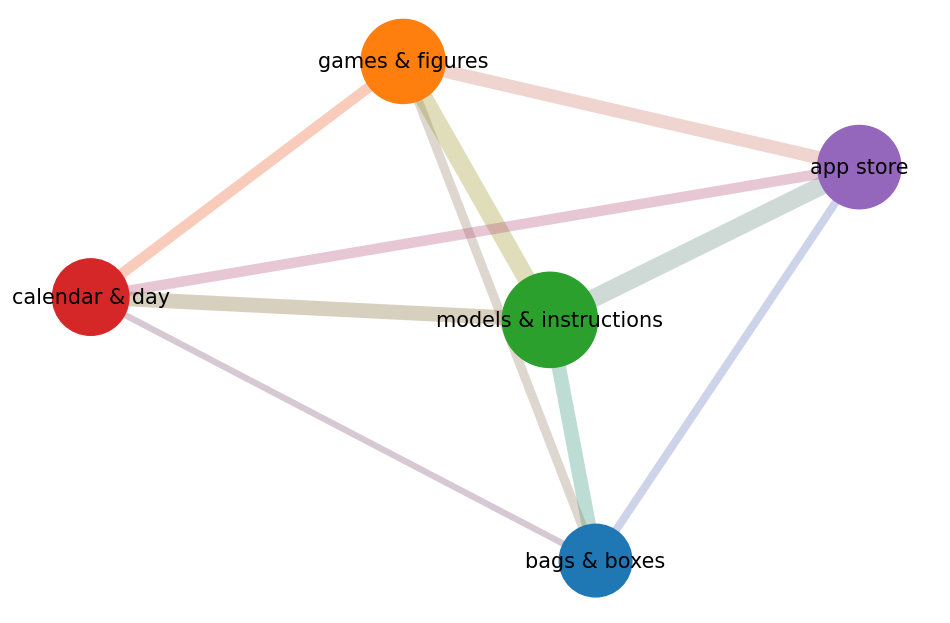

In [18]:
draw_network(G, node_size_list, node_color_list, edge_width_list, edge_color_list, node_label_dict) # visualize semantic network

# step 3: exclude nodes that are in topics which have stop-words 
stopwords: food, drinks, fredagsbar, cantine, made in america, translate ideas, garbage cans, p-shop <br/>
NB: none of our topics had any of these words, but I will remove topic 4 (dimension-3) with "calendar", "advent", "day", "christmas". 

## step 3.1: assign maximum topic to each thread

In [20]:
data["W_max"] = np.argmax(W, axis=1) # assign maximum topic to each thread
data["W_val"] = np.max(W, axis=1) # assign value to each thread (potentially not used)

## step 3.2: remove threads that are mostly in topic 4 (dimension-3)

In [21]:
data_subset = data[data["W_max"] != 3] # remove dimension-3

## step 3.3: get an overview (i.e. how much data have we filtered away)

In [22]:
print(f"number of threads before removing those with 'Calendar & Day' as main topic: {len(data)}")
print(f"number of threads after removing those with 'Calendar & Day' as main topic: {len(data_subset)}")
print(f"effectively removed: {len(data)-len(data_subset)} threads")

number of threads before removing those with 'Calendar & Day' as main topic: 108
number of threads after removing those with 'Calendar & Day' as main topic: 93
effectively removed: 15 threads


# step 4: all comments (not posts) into one "document"
NB: we already have this in the "Comment" column (see below)

In [25]:
# see the fourth column (Comment)
data_subset.head(3)

,Submission.ID,Title,Body,Comment,text,clean_txt,W_max,W_val
0,4,Make it easier to open the box,Often I see a LEGO box get torn open because i...,"Thank you Camilla, that would be great! Whethe...",Make it easier to open the box Often I see a L...,make it easier to open the box often i see a l...,0,0.238333
1,91,Reconnect with childhood,When taking visitors through the Idea House I ...,I felt so nostalgic the day I saw horses in th...,Reconnect with childhood When taking visitors ...,reconnect with childhood when taking visitors ...,4,0.217200
3,51,Garbage Cans in Billund Parking House,The parking house in Billund provides great pa...,Good suggestion Edwin! I have also been there ...,Garbage Cans in Billund Parking House The park...,garbage cans in billund parking house the park...,4,0.161155


# step 5: run sentiment analysis
## step 5.1: function to compute sentiment of "comments"

In [26]:
## step 5: run sentiment analysis ##
# function for computing sentiment
def sentiment_score(text: str) -> float:
    if not text or not isinstance(text, str):
        return np.nan
    #text = utils.text.normalize(text)
    sentence_object = Sentence(text)
    classifier.predict(sentence_object)
    res = sentence_object.labels[0].to_dict()
    sign: str = res["value"]
    magnitude: float = res["confidence"]
    if sign == "POSITIVE":
        return magnitude
    return -magnitude

## step 5.2: use the function 
NB: this takes a minute.

In [27]:
data_subset["sentiment"] = [sentiment_score(x) for x in data_subset["Comment"]] # for each row, calculate sentiment score of the "Comment" column

## step 5.3: plot the sentiment distribution

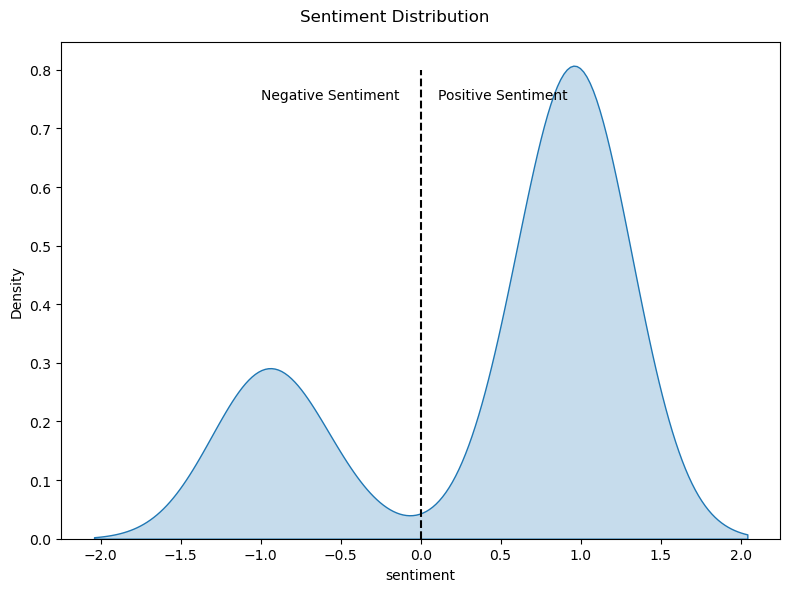

In [28]:
# many really positive (around 1) and some negative (around -1)
fig, ax = plt.subplots(figsize=(8, 6), dpi=100, facecolor='w', edgecolor='k') # plot setup
sns.kdeplot(data = data_subset, x = "sentiment", fill = "tab:blue"); # make the plot
plt.suptitle("Sentiment Distribution") # title
ax.annotate('Positive Sentiment', xy=(0.11, 0.75),  xycoords='data') # annotation
ax.annotate('Negative Sentiment', xy=(-1, 0.75), xycoords='data') # annotation
ax.vlines(x = 0, ymin = 0, ymax = 0.8, color = 'black', linestyle = 'dashed') # dashed vertical line
plt.tight_layout() # layout

## step 5.4: check the most negative & most positive comment (validation)

In [29]:
# check the least and most positive comments # 
negative_comment = data_subset[data_subset["sentiment"] == data_subset["sentiment"].min()][["Comment", "sentiment"]] # most negative comment
positive_comment = data_subset[data_subset["sentiment"] == data_subset["sentiment"].max()][["Comment", "sentiment"]] # most positive comment

print(f"Most negative comment has sentiment: {negative_comment['sentiment'].values} \n{negative_comment['Comment'].values}\n") # print most negative comment
print(f"Most positive comment has sentiment: {positive_comment['sentiment'].values} \n{positive_comment['Comment'].values}") # print most positive comment

Most negative comment has sentiment: [-0.99997854] 
['I like the idea but not sure that children will be patient enough, once they start building something, they will want to carry on doing so. Maybe a story book or picture book would be an alternative to take their minds off the set building. These could be kept under the counter and given to anyone who wants one when they buy their set. The stories could be generic and feature Max from LEGO Club.']

Most positive comment has sentiment: [0.99997413] 
["Tom And Jerry is a very famous Carton series when I was a child and I hope LEGO will have these figures built by bricks in future. I would be great to have LEGO Scooby Doo, Go for it!!! I agree, Tom and Jerry is one of those timeless cartoons which will be around for a very long time. I know children who still love them. As a huge Scooby-Doo fan myself, I think this is a fantastic idea! Scooby-Doo as a cartoon has been around since 1969, and is still continuing. A show that has lasted t

# step 6 + 7: rank comments based on sentiment + exclude bottom half

In [30]:
half_of_records = int(round(len(data_subset)/2,0)) # get half of the length of data
data_subset = data_subset.sort_values('sentiment', ascending = False) # sort descending (based on sentiment) so that high sentiment is in the top of our dataframe
data_sentiment = data_subset.head(half_of_records) # select the half of records with highest (positive) sentiment (the top 50% of rows)

## step 7.1: check how positive the new selection of data is compared to before

In [31]:
sentiment_new = data_sentiment["sentiment"].mean()
sentiment_old = data_subset["sentiment"].mean()
print(f"average (mean) sentiment in new subset (best half): {round(sentiment_new, 3)}")
print(f"average (mean) sentiment before subsetting: {round(sentiment_old, 3)}")

average (mean) sentiment in new subset (best half): 0.995
average (mean) sentiment before subsetting: 0.443


# step 8: rank remaining posts 
### (comments: 60%, likes: 35%, likes on comments: 5%)
#### I interpreted this as: 
##### (1) comments = number of comments on original post
##### (2) likes = number of "votes" on original post
##### (3) likes on comments = number of "votes" on all comments for each original post
##### (4) scale all these metrics into (0, 1) and weight based on percentages provided

## step 8.1: get the number of comments on original posts

In [38]:
IDS = data_sentiment[["Submission.ID"]] # select only the IDs that are in "good" topics and have high (positive) sentiment
comment_IDS = comments.merge(IDS, on = "Submission.ID", how = "inner") # join with original "comments" data
comment_count = comment_IDS.groupby("Submission.ID").size().reset_index(name = 'n_comments') # group by ID and calculate the number of comments with that ID
comment_count.sort_values('n_comments', ascending=False).head(3) # print the top three most commented upon posts

,Submission.ID,n_comments
0,4,17
38,194,15
19,115,14


## step 8.2: get the number of votes on original posts (2)

In [39]:
ideas_IDS = ideas.merge(IDS, on = "Submission.ID", how = "inner") # select only ideas (original posts) that are in "good" topics and have high (positive) sentiment
original_votes = ideas_IDS[["Submission.ID", "Number.of.Votes"]] # select just the two columns that we need 
original_votes = original_votes.rename(columns = {'Number.of.Votes': 'post_votes'})
original_votes.sort_values('post_votes', ascending=False).head(3) # print the top three most voted upon posts

,Submission.ID,post_votes
0,4,25
42,194,20
2,65,19


## step 8.3: get the number of votes on comments

In [40]:
# (3) number of votes on comments 
comment_votes = comment_IDS.groupby('Submission.ID')['Number of votes'].sum().reset_index(name = 'comment_votes') # group by Submission.ID and get the sum of number of votes 
comment_votes.sort_values('comment_votes', ascending=False).head(3) # print top three most voted upon comments 

,Submission.ID,comment_votes
29,168,11
3,19,8
6,50,5


## step 8.4: combine this into one dataframe

In [41]:
# (4) now we have to combine these dataframes # 
merge_comments = comment_votes.merge(comment_count, on = "Submission.ID", how = "inner")
merge_posts = merge_comments.merge(original_votes, on = "Submission.ID", how = "inner") 
merge_posts.head(5) # print it 

,Submission.ID,comment_votes,n_comments,post_votes
0,4,4,17,25
1,13,1,3,0
2,16,0,1,4
3,19,8,9,14
4,24,2,4,10


In [42]:
# and now we scale everything so that we can do a weighted sum #
numeric_cols = merge_posts.drop('Submission.ID', axis=1) # remove Submission.ID because we do not want to normalize this column
df_norm = (numeric_cols-numeric_cols.min())/(numeric_cols.max()-numeric_cols.min()) # normalize all of the other columns (all values between 0 and 1)
df_norm = pd.concat((df_norm, merge_posts['Submission.ID']), 1) # add Submission.ID again
df_norm.head(5)

/tmp/ipykernel_660/2066110205.py:4: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  df_norm = pd.concat((df_norm, merge_posts['Submission.ID']), 1) # add Submission.ID again


,comment_votes,n_comments,post_votes,Submission.ID
0,0.363636,1.0000,1.00,4
1,0.090909,0.1250,0.00,13
2,0.000000,0.0000,0.16,16
3,0.727273,0.5000,0.56,19
4,0.181818,0.1875,0.40,24


In [43]:
# now we weight the columns #
df_norm["n_comments"] = [x*0.6 for x in df_norm["n_comments"]] # scale number of comments: 0.6 (60% weight)
df_norm["post_votes"] = [x*0.35 for x in df_norm["post_votes"]] # scale number of votes on post: 0.35 (35% weight)
df_norm["comment_votes"] = [x*0.05 for x in df_norm["comment_votes"]] # scale number of votes on comments: 0.05 (5% weight)

# and now we can take the sum across these columns # 
df_norm = df_norm.assign(weighted_sum = lambda x: x['n_comments'] + x["post_votes"] + x["comment_votes"]) # sum across columns (weighted sum)
df_norm = df_norm.sort_values('weighted_sum', ascending=False) # sort them by the weighted score 
df_norm.head(5) # display top five 

,comment_votes,n_comments,post_votes,Submission.ID,weighted_sum
0,0.018182,0.6000,0.350,4,0.968182
38,0.009091,0.5250,0.280,194,0.814091
19,0.018182,0.4875,0.168,115,0.673682
8,0.018182,0.3000,0.266,65,0.584182
3,0.036364,0.3000,0.196,19,0.532364


In [44]:
# 8: get the top 5 posts and text #
top5_IDS = df_norm[["Submission.ID", "weighted_sum"]].head(5) # take out the top 5 IDS
top5_text = top5_IDS.merge(data, on = "Submission.ID", how = "inner")

# step 8.5: DISPLAY FINAL RESULT 

In [45]:
# display top ideas # 
pd.set_option('display.max_colwidth', None) # so that we can see all the output
for idx, row in top5_text.iterrows(): 
    print(f"The number {idx+1} rated idea is:")
    #print(row["Submission.ID"])
    print(f"--> {row['Title']}:")
    print(f"{row['Body']} \n")

The number 1 rated idea is:
--> Make it easier to open the box:
Often I see a LEGO box get torn open because it is not obvious how to open it without damaging it. I think it would be nice if there was an easier way to open the box. 

The number 2 rated idea is:
--> New element: Plate with knobs on both sides:
An element that really could give many new building ways and posibilities would be plates with knobs on both sides. Like a 2x4 plate without tubeside,  but instead knobs equal to the other side.. Same we could do woth 2x2,  1x2 and so on…This would really give news ways of building,  and one don't need to build tube against tube side,  like the B-wing... I really dont like the cracks of air between the plates  and here this would be an awesome solution..Update: I uploaded a pictures of an element  we use internaly here in Verification  for setup up bricks for measurement. This is created specially for this... but simular for building, just with equal number of knobs on both sides 

# side-note: extra run

## (e1) Remove threads with stop words from step 3. Removing the irrelevant words/posts

In [46]:
words = ["food", "drinks", "fredagsbar", "cantine", "made in america", "translate ideas", "garbage cans", "p-shop"] # list of stop words (remember that we match exactly, so "drinks" will not match "drink")
data["matches_stopword"] = [any(words in x for words in words) for x in data["clean_txt"]] # check how many threads match ANY of the stopwords
data.groupby('matches_stopword').size().head() # only 4 threads out of 108 threads match the stopwords
data_stopwords = data[data["matches_stopword"] == False] # select the 104 threads that do not match stopwords

## (e2) Rank the dataset using scores from step 8
NB: we are using basically the same code as in the main pipeline.

In [47]:
# extra: 2 -- now we rank them in the same way as before (I omit explanation this time) # 

# get the new IDS
IDS = data_stopwords[["Submission.ID"]]

# number of comments
comment_IDS = comments.merge(IDS, on = "Submission.ID", how = "inner") # join with original "comments" data
comment_count = comment_IDS.groupby("Submission.ID").size().reset_index(name = 'n_comments') # group by ID and calculate the number of comments with that ID

# number of votes on original posts
ideas_IDS = ideas.merge(IDS, on = "Submission.ID", how = "inner") # select only ideas (original posts) that are in "good" topics and have high (positive) sentiment
original_votes = ideas_IDS[["Submission.ID", "Number.of.Votes"]] # select just the two columns that we need 
original_votes = original_votes.rename(columns = {'Number.of.Votes': 'post_votes'})

# number of votes on comments
comment_votes = comment_IDS.groupby('Submission.ID')['Number of votes'].sum().reset_index(name = 'comment_votes') # group by Submission.ID and get the sum of number of votes 

# merge
merge_comments = comment_votes.merge(comment_count, on = "Submission.ID", how = "inner")
merge_posts = merge_comments.merge(original_votes, on = "Submission.ID", how = "inner")

# normalize
numeric_cols = merge_posts.drop('Submission.ID', axis=1) # remove Submission.ID because we do not want to normalize this column
df_norm = (numeric_cols-numeric_cols.min())/(numeric_cols.max()-numeric_cols.min()) # normalize all of the other columns (all values between 0 and 1)
df_norm = pd.concat((df_norm, merge_posts['Submission.ID']), 1) # add Submission.ID again

# now we weight the columns #
df_norm["n_comments"] = [x*0.6 for x in df_norm["n_comments"]] # scale number of comments: 0.6 (60% weight)
df_norm["post_votes"] = [x*0.35 for x in df_norm["post_votes"]] # scale number of votes on post: 0.35 (35% weight)
df_norm["comment_votes"] = [x*0.05 for x in df_norm["comment_votes"]] # scale number of votes on comments: 0.05 (5% weight)

# and now we can take the sum across these columns # 
df_norm = df_norm.assign(weighted_sum = lambda x: x['n_comments'] + x["post_votes"] + x["comment_votes"]) # sum across columns (weighted sum)
df_norm = df_norm.sort_values('weighted_sum', ascending=False) # sort them by the weighted score 

# get top 5 #
top5_IDS = df_norm[["Submission.ID", "weighted_sum"]].head(5) # take out the top 5 IDS
top5_text = top5_IDS.merge(data, on = "Submission.ID", how = "inner")

/tmp/ipykernel_660/2351572548.py:25: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  df_norm = pd.concat((df_norm, merge_posts['Submission.ID']), 1) # add Submission.ID again


## e3: display results from second pipeline

In [48]:
# display top ideas # 
## NB: only the top rated idea and number 3 is the same (so even though we only remove 4 threads those were important) 
pd.set_option('display.max_colwidth', None) # so that we can see all the output
for idx, row in top5_text.iterrows(): 
    print(f"The number {idx+1} rated idea is:")
    #print(row["Submission.ID"])
    print(f"--> {row['Title']}:")
    print(f"{row['Body']} \n")

The number 1 rated idea is:
--> Make it easier to open the box:
Often I see a LEGO box get torn open because it is not obvious how to open it without damaging it. I think it would be nice if there was an easier way to open the box. 

The number 2 rated idea is:
--> Pick a brick in P-shop:
IÂ´m so happy that we in the P-shop now has the oppertunity to fill a bag of minifigure parts, wich I assume would just go to waste/scrap. Why donÂ´t we expand this oppertunity to include bricks as well? This would be a win/win situation for the company and the employee. The company reduces the waste/scrap (Planet Promis) and the employee has access to bricks with a discount. 

The number 3 rated idea is:
--> New element: Plate with knobs on both sides:
An element that really could give many new building ways and posibilities would be plates with knobs on both sides. Like a 2x4 plate without tubeside,  but instead knobs equal to the other side.. Same we could do woth 2x2,  1x2 and so on…This would rea

In [49]:
## why do we see "P-shop" as the second highest rated idea? ## 
# well... we have made our text lower, but we remove special characters (e.g. "-") so we actually get "pshop" which was not a stopword of ours 
pshop = normalizing_text('P-shop') # applying our text normalization to "P-shop" 
print(pshop)

pshop
